In [ ]:
import pandas as pd
import numpy as np
import math as math
import random
from sklearn.utils import shuffle
import sklearn.preprocessing  as prepro
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [ ]:
# Create Data class which has load_data method
class Data:
    def __init__(self):
        print("Data object initiated")

    def Load_data(self,filepath,format='csv'):
        """ Read data from file and return data """
        if format == 'csv':
            return pd.read_csv(filepath)
        elif format == 'xlsx':
            return pd.read_excel(filepath)

In [ ]:
data_file = 'https://raw.githubusercontent.com/ShivaliPatel/Data-science-projects/refs/heads/master/Telco_customer_churn/Data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
extension = 'csv'

In [ ]:
data = Data()
df_raw = data.Load_data(data_file, extension)
df_raw.sample(5)

Data object initiated


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1719,2081-VEYEH,Male,0,No,No,3,Yes,No,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,107.95,318.6,No
4025,2984-MIIZL,Male,0,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.80,321.9,Yes
5728,3374-LXDEV,Female,0,No,No,13,Yes,Yes,Fiber optic,No,...,Yes,Yes,No,No,Month-to-month,No,Electronic check,89.40,1132.35,Yes
289,3580-REOAC,Male,0,No,No,10,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),44.85,435.4,Yes
5109,7113-HIPFI,Male,0,Yes,Yes,66,Yes,No,DSL,Yes,...,Yes,Yes,No,No,Two year,No,Mailed check,65.85,4097.05,No


In [ ]:
df_raw.shape

(7043, 21)

## Data Tranformation & Renaming

In [ ]:
def Data_transformation_renaming(df_raw):
    """ Rename column names and transformed into proper format and return dataframe """
    df_cal = df_raw.copy()

    df_cal.rename(columns={'gender':'Gender'
                       ,'customerID':'CustomerID'
                       ,'Contract':'ContractType'
                       ,'InternetService':'InternetServiceType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)


    df_cal['Partner'] = df_cal.Partner.map({'Yes':1,'No':0})
    df_cal['Dependents'] = df_cal.Dependents.map({'Yes':1,'No':0})

    df_cal['PhoneService'] = df_cal.PhoneService.map({'Yes':1,'No':0})
    df_cal['MultipleLines'] = df_cal.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})

    df_cal['InternetService'] = df_cal.InternetServiceType.map({'DSL':1,'Fiber optic':1,'No':0})
    df_cal['OnlineSecurity'] = df_cal.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['OnlineBackup'] = df_cal.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['DeviceProtection'] = df_cal.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['TechSupport'] = df_cal.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['StreamingTV'] = df_cal.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['StreamingMovies'] = df_cal.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['PaperlessBilling'] = df_cal.PaperlessBilling.map({'Yes':1,'No':0})
    df_cal['Churn'] = df_cal.Churn.map({'Yes':1,'No':0})

    # Data mining
    df_cal['IsContracted'] = df_cal.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})

    # Data transformation

    # Converting TotalCharges into Numeric, but some of the records are empty, so first we need to deal with them.
    df_cal.loc[df_cal['TotalCharges']==' ','TotalCharges'] = np.nan

    # First we convert TotalCharges to float and then replace with tenure * monthly charges
    df_cal['TotalCharges'] = df_cal['TotalCharges'].astype('float64')
    df_cal.loc[df_cal['TotalCharges'].isnull()==True,'TotalCharges'] = df_cal['MonthlyCharges'] * df_cal['Tenure']
    return df_cal

In [ ]:
df_cal = Data_transformation_renaming(df_raw)

In [ ]:
df_cal.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,OnlineSecurity,...,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted
0,7590-VHVEG,Female,0,1,0,1,0,0,DSL,0,...,0,0,Month-to-month,1,Electronic check,29.85,29.85,0,1,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,...,0,0,One year,0,Mailed check,56.95,1889.50,0,1,1
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,1,0
3,7795-CFOCW,Male,0,0,0,45,0,0,DSL,1,...,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,1
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,0,0,Month-to-month,1,Electronic check,70.70,151.65,1,1,0


In [ ]:
cat_cols = ["Gender","Partner","Dependents","SeniorCitizen","PhoneService","MultipleLines"
                    ,"InternetServiceType","OnlineSecurity","OnlineBackup","DeviceProtection"
                    ,"TechSupport","StreamingTV","StreamingMovies","IsContracted"
                    ,"ContractType","PaperlessBilling","PaymentMethod"]


num_cols = ["Tenure","MonthlyCharges","TotalCharges"]

target_col = 'Churn'

# spliting categorical columns into Nominal and Binary columns

nominal_cols = ['Gender','InternetServiceType','PaymentMethod','ContractType']

binary_cols = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity'
               ,'OnlineBackup' ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies'
               ,'PaperlessBilling','InternetService', 'IsContracted']

In [ ]:
df = df_raw.copy()
df.drop('customerID',axis=1,inplace=True)
df.drop('Churn',axis=1,inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
object_cols = df.select_dtypes(include=['object']).columns
encoder = {}
for col in object_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoder[col] = le

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

## Model Building

In [ ]:
df_model = Data_transformation_renaming(df_raw)

**Train-test-split**

In [ ]:
def Shuffle_data(df):
    """ Return shuffled data based on rows """
    return shuffle(df).reset_index().drop('index'
                                          , axis = 1)

def One_hot_encoding(df,feature):
    """ Apply one hot encoding to given features """
    return pd.concat([df
                      , pd.get_dummies(df[feature])]
                     , axis = 1)

def Merge_df(data, features):
    """ Return merge dataframe with given features"""
    merged_df = pd.DataFrame()
    for feature in features:
        merged_df = pd.concat([merged_df, data[feature]]
                              , axis = 1)
    return merged_df

def Normalize_feature(feature):
    """ Return normalized features """
    return prepro.StandardScaler().fit_transform(feature)

def Normalize_df(data, cols):
    """ Normalize features """
    for col in cols:
        data[col] = Normalize_feature(data[[col]])

    return data

def Create_model_df(df, col_cols, nom_cols, binary_cols, num_cols, target_col):
    """ Preparing data for modelling """

    df_model = Merge_df(df , [col_cols, num_cols, target_col])
    df_model = Shuffle_data(df_model)
    df_model = One_hot_encoding(df_model, nom_cols)

    df_model.drop(nom_cols, axis = 1, inplace = True)

    df_model = Normalize_df(df_model, num_cols)

    return (df_model.loc[:, ~df_model.columns.isin(target_col)]
            , df_model[target_col].values.flatten())


def Train_test_df(feature, target, test_size,random_state = 42):
    """ Spliting data to train and test"""
    return train_test_split(feature
                     ,target
                     ,test_size= test_size
                     ,random_state= random_state)

In [ ]:
df_model_feature ,df_model_target = Create_model_df(df_model
                                                    , cat_cols
                                                    , nominal_cols
                                                    , binary_cols
                                                    , num_cols
                                                    , [target_col])

In [ ]:
x_train, x_test, y_train, y_test = Train_test_df(df_model_feature
                                                 , df_model_target
                                                 , test_size = 0.2)

In [ ]:
print("----------------------------")
print("Original features shape, ", df_model_feature.shape)
print("Original target shape, ", df_model_target.shape)
print("x train shape, ", x_train.shape)
print("y train shape, ", y_train.shape)
print("x test shape, ", x_test.shape)
print("y test shape, ", y_test.shape)
print("----------------------------")

----------------------------
Original features shape,  (7043, 28)
Original target shape,  (7043,)
x train shape,  (5634, 28)
y train shape,  (5634,)
x test shape,  (1409, 28)
y test shape,  (1409,)
----------------------------


### **Class Imbalance**

In [ ]:
def Generate_bar_graph(x, y, x_title, y_title, chart_title, color='salmon'):
    fig, ax = plt.subplots()
    ax.bar(range(len(x)), y, width=0.75, color=['skyblue','salmon'], alpha=0.6)

    plt.xticks(range(len(x)), x)
    plt.title(chart_title, fontsize=14)
    plt.xlabel(x_title, fontsize=13)
    plt.ylabel(y_title, fontsize=13)
    plt.grid(False)  # ✅ Fix applied here
    plt.yticks(fontsize=10)
    plt.ylim(0, max(y) + 0.1)

    for spine in plt.gca().spines.values():
        spine.set_visible(False if spine.spine_type != 'bottom' else True)

    for i, v in enumerate(y):
        ax.text(i, v + 0.05, f"{round(v * 100, 2)}%", fontsize=13, ha='center')

    plt.show()


/tmp/ipython-input-189-3833833582.py:1: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



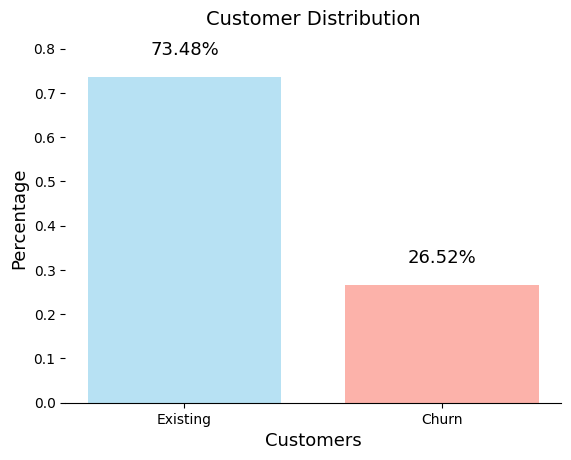

In [ ]:
Churn_rate = pd.value_counts(y_train) / len(y_train)
Generate_bar_graph(Churn_rate.index.map({0:'Existing',1:"Churn"})
                   , Churn_rate.values
                   , 'Customers'
                   , 'Percentage'
                   , 'Customer Distribution')

**Upsampling the Data**

In [ ]:
# Upsampling using SMOTE
sm = SMOTE(random_state = 42)
x_train_sm , y_train_sm = sm.fit_resample(x_train,y_train)

In [ ]:
print("----------------------------")
print("Original x train shape, ", x_train.shape)
print("Resample x train shape, ", x_train_sm.shape)
print("----------------------------")

----------------------------
Original x train shape,  (5634, 28)
Resample x train shape,  (8280, 28)
----------------------------


/tmp/ipython-input-192-2830533350.py:1: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



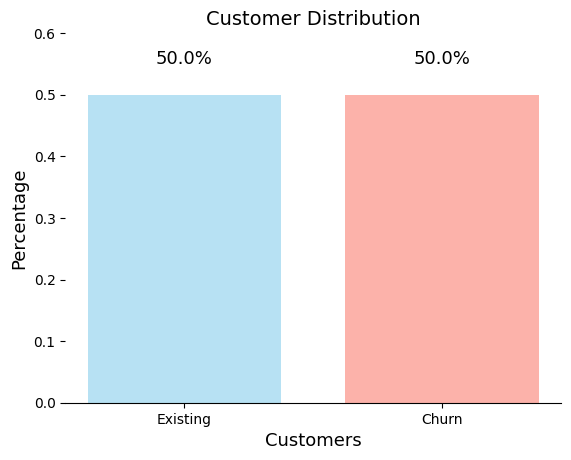

In [ ]:
Churn_rate = pd.value_counts(y_train_sm) / len(y_train_sm)
Generate_bar_graph(Churn_rate.index.map({0:'Existing',1:"Churn"})
                   , Churn_rate.values
                   , 'Customers'
                   , 'Percentage'
                   , 'Customer Distribution')

## Model Development

**Logistic Regression**

In [ ]:
lr = LogisticRegression(random_state=42,class_weight='balanced')
lr.fit(x_train_sm, y_train_sm)

LogisticRegression(class_weight='balanced', random_state=42)

In [ ]:
print('actual :       ',y_test[:10])
print('Hard Predict : ',lr.predict(x_test[:10]))

actual :        [1 1 0 0 0 0 1 1 0 0]
Hard Predict :  [1 1 0 0 1 1 0 1 0 0]


In [ ]:
print('Soft Predict : \n',lr.predict_proba(x_test[:10]))

Soft Predict : 
 [[0.12137255 0.87862745]
 [0.28733517 0.71266483]
 [0.87324727 0.12675273]
 [0.93381504 0.06618496]
 [0.30758164 0.69241836]
 [0.3723131  0.6276869 ]
 [0.50869803 0.49130197]
 [0.22991448 0.77008552]
 [0.59587468 0.40412532]
 [0.66277023 0.33722977]]


<Axes: >

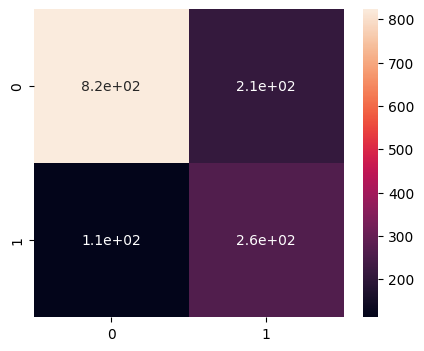

In [ ]:
plt.figure(figsize=(5,4))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lr.predict(x_test))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1034
           1       0.55      0.70      0.62       375

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409



In [ ]:
from sklearn.metrics import roc_curve, auc , roc_auc_score
print('ROC-AUC score : ',roc_auc_score(y_test, lr.predict(x_test)))

ROC-AUC score :  0.7486357188910381


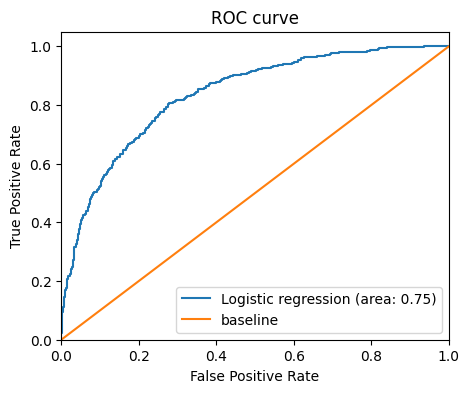

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, lr.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.title('ROC curve')
plt.plot(fpr, tpr , label= 'Logistic regression (area: %0.2f)' % metrics.roc_auc_score(y_test, lr.predict(x_test)))
plt.plot([0, 1], [0, 1], label = 'baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Random Forest**

In [ ]:
rf = RandomForestClassifier(random_state=42,
                            class_weight='balanced',
                            n_estimators=5,
                            max_features=5)
rf.fit(x_train_sm, y_train_sm)

RandomForestClassifier(class_weight='balanced', max_features=5, n_estimators=5,
                       random_state=42)

In [ ]:
y_pred = rf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[846, 188],
       [138, 237]])

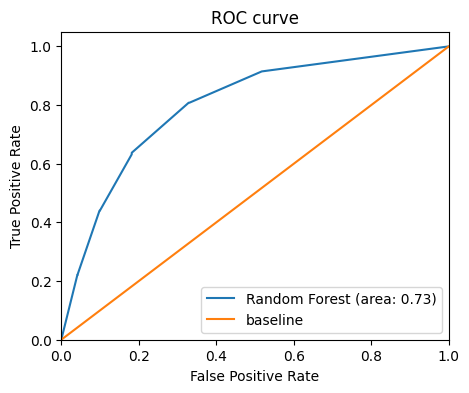

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, rf.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.title('ROC curve')
plt.plot(fpr, tpr , label= 'Random Forest (area: %0.2f)' % metrics.roc_auc_score(y_test, rf.predict(x_test)))
plt.plot([0, 1], [0, 1], label = 'baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(classification_report(y_test,rf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1034
           1       0.56      0.63      0.59       375

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409



In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf,x_train_sm,y_train_sm,cv = 5, scoring = 'roc_auc').mean()

np.float64(0.8847153667530165)

In [ ]:
cross_val_score(rf,x_train_sm,y_train_sm,cv = 5, scoring = 'accuracy').mean()

np.float64(0.8134057971014492)

<Axes: >

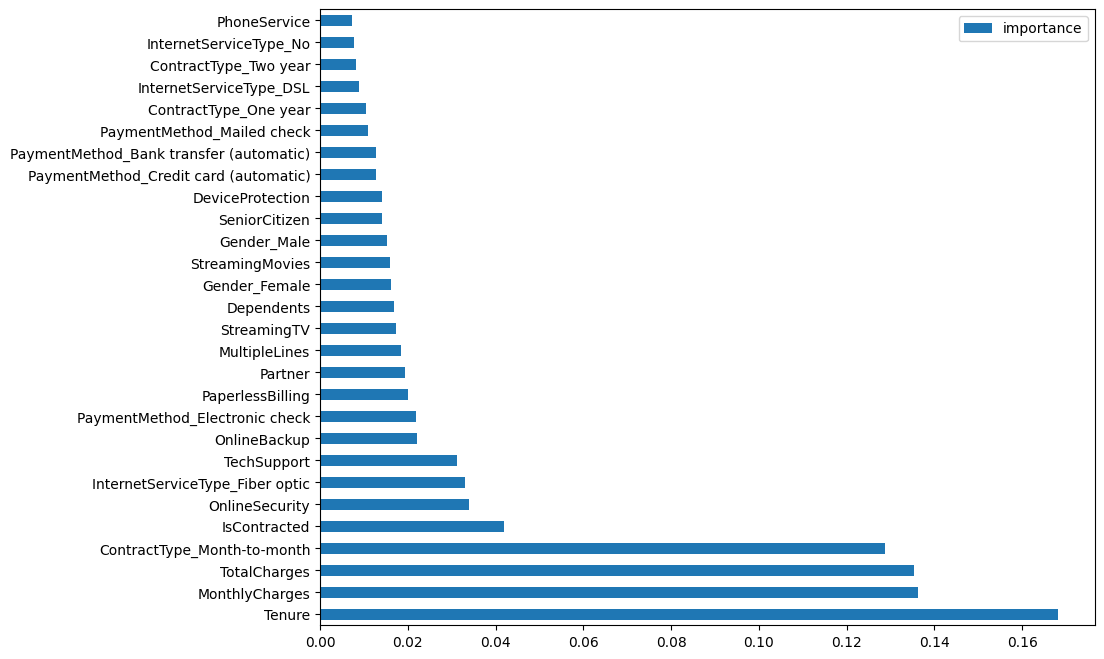

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot(kind='barh', figsize=(10, 8))

**XgBoosting**

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42,
                            class_weight='balanced',
                            n_estimators=5,
                            max_features=5)
xgb.fit(x_train_sm, y_train_sm)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:15:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "max_features" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_features=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=5,
              n_jobs=None, ...)

In [ ]:
y_pred_xgb = xgb.predict(x_test)
confusion_matrix(y_test, y_pred_xgb)

array([[811, 223],
       [ 99, 276]])

In [ ]:
print(classification_report(y_test,xgb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1034
           1       0.55      0.74      0.63       375

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf,x_train_sm,y_train_sm,cv = 5, scoring = 'roc_auc').mean()

np.float64(0.8847153667530165)

## **Hyperparameter Tuning and Model Evaluation**

In [ ]:
def Parameter_tunning(x, y, models, clsModelsNm, parameters, score):

    tuned_params = {}
    for i,model in enumerate(models):
        print(clsModelsNm[i])
        grid = GridSearchCV(estimator = model
                            , cv = 5
                            , param_grid = parameters[clsModelsNm[i]]
                            , scoring = score
                            , n_jobs = 3)
        grid.fit(x,y)
        print(grid.best_score_)
        print(grid.best_params_)
        tuned_params[clsModelsNm[i]] = {'params':grid.best_params_}

    return tuned_params

In [ ]:
clsModelsNm = ["Logistic Regression", "Random Forest", "XgBoost"]
scoreMatrix = ['accuracy','precision','recall','f1','neg_log_loss']

clsParams = {'Logistic Regression':{'C':[0.1, 0.5, 1, 5, 10, 15, 20, 100]
                                   ,'penalty':['l1','l2']
                                    }
             , 'Random Forest': {'max_depth':[5,10,15,20]
                                ,'n_estimators':[100,150,200]
                                ,'max_features':['sqrt',0.7,0.2]
                                ,'min_samples_leaf':[1,10,20]
                                 }
             , 'XgBoost': {'learning_rate': [0.05, 0.1, 0.2]
                                    ,'n_estimators':[50,100,200]
                                    ,'max_depth':[3,5,7]
                                    ,'min_child_weight': [1, 5, 10]
                                    ,'subsample': [0.1, 0.5 , 1]
                                    }
            }

In [ ]:
random_state = 42

In [ ]:
clsLR = LogisticRegression(random_state=random_state, solver='liblinear')
clsRF = RandomForestClassifier(random_state = random_state)
clsXGB = XGBClassifier(random_state = random_state)

clsModels = [clsLR, clsRF, clsXGB]

In [ ]:
# import time
# start = time.time()

# tuned_params = Parameter_tunning(x_train, y_train, clsModels, clsModelsNm, clsParams, 'neg_log_loss')

# end = time.time()
# print(end - start)

In [ ]:
!pip install optuna

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

In [ ]:
def Cross_validation_score(clsModels, clsModelsNm, clsSample, scoreMatrix):
    """ Cross validation using cross_val_score method """
    for i,model in enumerate(clsModels):
        print("===============================================")
        print(clsModelsNm[i])

        for j, sample in enumerate(clsSample):
            print("************************************************")
            print(sample[2])

            for score in scoreMatrix:
                scores = cross_val_score(model, sample[0], sample[1], cv=3 , scoring = score)
                print(score, " score:", scores.mean())

            y_scores = cross_val_predict(model, sample[0], sample[1], cv=3, method="predict_proba")


            precisions, recalls, thresholds = metrics.precision_recall_curve(sample[1], y_scores[:][:,1])
            # plot_precision_recall_vs_thresold(precisions, recalls, thresholds)
            score_matrix = pd.DataFrame({'Precisions': precisions[:-1]
                                ,'Recalls': recalls[:-1]
                                ,'F1': 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1]+recalls[:-1])
                                ,'Threshold': thresholds
                               })
            #print("When percision and recall are same \n" , score_matrix[ score_matrix['Precisions'] == score_matrix['Recalls']] )
            print("When F1 score is max \n" , score_matrix[ score_matrix['F1'] == max(score_matrix['F1'])] )

In [ ]:
clsLR_sm = LogisticRegression(random_state = random_state
                           , C = 0.5
                           , penalty = 'l1'
                           , solver = 'liblinear')

clsRF_sm = RandomForestClassifier(random_state = random_state
                               , max_depth = 5
                              , n_estimators = 100
                              , max_features = 'sqrt'
                              , min_samples_leaf = 20 )

clsGB_sm = XGBClassifier(random_state = random_state
                              , max_depth = 5
                              , n_estimators = 100
                              , learning_rate = 0.05
                              , min_child_weight = 5
                              , subsample = 0.5)

clsModels_sm = [clsLR_sm, clsRF_sm, clsGB_sm]

Cross_validation_score(clsModels_sm, clsModelsNm, [(x_train_sm, y_train_sm,'Upsampled data')], scoreMatrix)

Logistic Regression
************************************************
Upsampled data
accuracy  score: 0.8003623188405798
precision  score: 0.7940503821558055
recall  score: 0.8118357487922706
f1  score: 0.7957608767974705
neg_log_loss  score: -0.4375493393950265
When F1 score is max 
       Precisions   Recalls        F1  Threshold
3588    0.764919  0.866908  0.812726   0.417764
Random Forest
************************************************
Upsampled data
accuracy  score: 0.7793478260869566
precision  score: 0.7447578011142206
recall  score: 0.8502415458937199
f1  score: 0.7937788850305995
neg_log_loss  score: -0.46295979786248004
When F1 score is max 
       Precisions   Recalls        F1  Threshold
3096    0.723143  0.895894  0.800302   0.446561
XgBoost
************************************************
Upsampled data
accuracy  score: 0.8042270531400967
precision  score: 0.7854841535524223
recall  score: 0.8379227053140097
f1  score: 0.8088640734722355
neg_log_loss  score: -0.4231450727

In [ ]:
from lightgbm import LGBMClassifier

### **Tuning for best model with its best Hyperparameter**

In [ ]:
def objective(trial):
  classifier_name = trial.suggest_categorical('classifier_name',['LogisticRegression','RandomForestClassifier','XGBClassifier'])

  if classifier_name == 'LogisticRegression':
    penalty = trial.suggest_categorical('penalty',['l1','l2'])
    C = trial.suggest_float('C',0.1,10)
    model = LogisticRegression(random_state = random_state
                              , penalty = penalty
                              , C = C
                              , solver = 'liblinear')

  elif classifier_name == 'RandomForestClassifier':
    max_depth = trial.suggest_int('max_depth',5,10)
    n_estimators = trial.suggest_int('n_estimators',50,250)
    max_features = trial.suggest_categorical('max_features',['sqrt',0.7,0.2])
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)
    bootstrap = trial.suggest_categorical('bootstrap',[True,False])
    model = RandomForestClassifier(random_state = random_state
                                  , max_depth = max_depth
                                  , n_estimators = n_estimators
                                  , max_features = max_features
                                  , min_samples_leaf = min_samples_leaf
                                  , bootstrap = bootstrap)

  elif classifier_name == 'XGBClassifier':
    max_depth = trial.suggest_int('max_depth',5,10)
    n_estimators = trial.suggest_int('n_estimators',50,250)
    learning_rate = trial.suggest_float('learning_rate',0.01,0.1)
    min_child_weight = trial.suggest_int('min_child_weight',1,10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)
    min_samples_split = trial.suggest_int('min_samples_split',1,10)
    subsample = trial.suggest_float('subsample',0.1,1)
    model = XGBClassifier(random_state = random_state
                          , max_depth = max_depth
                          , n_estimators = n_estimators
                          , learning_rate = learning_rate
                          , min_child_weight = min_child_weight
                          , min_samples_leaf = min_samples_leaf
                          , min_samples_split = min_samples_split
                          , subsample = subsample)
  elif classifier_name == 'LightGBMClassifier':
    max_depth = trial.suggest_int('max_depth',5,10)
    n_estimators = trial.suggest_int('n_estimators',50,250)
    learning_rate = trial.suggest_float('learning_rate',0.01,0.1)
    min_child_weight = trial.suggest_int('min_child_weight',1,10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)
    min_samples_split = trial.suggest_int('min_samples_split',1,10)
    subsample = trial.suggest_float('subsample',0.1,1)
    model = LGBMClassifier(random_state = random_state,
                                max_depth = max_depth
                                , n_estimators = n_estimators
                                , learning_rate = learning_rate
                                , min_child_weight = min_child_weight
                                , min_samples_leaf = min_samples_leaf
                                , min_samples_split = min_samples_split
                                , subsample = subsample)
  score = cross_val_score(model, x_train_sm, y_train_sm, cv=3, scoring='recall').mean()

  return score

In [ ]:
study = optuna.create_study(direction='maximize',sampler = optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

[I 2025-07-06 20:17:34,252] A new study created in memory with name: no-name-2342b93e-7f55-47c5-a8d4-37bc7846e65a
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:17:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:17:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:17:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.


[I 2025-07-06 20:17:38,994] Trial 0 finished with value: 0.8282608695652174 and parameters: {'classifier_name': 'XGBClassifier', 'max_depth': 9, 'n_estimators': 213, 'learning_rate': 0.0853870771865438, 'min_child_weight': 10, 'min_samples_leaf': 7, 'min_samples_split': 10, 'subsample': 0

In [ ]:
best_trial = study.best_trial
print('best trial model is : ',best_trial.params)
print('best trial value is : ',best_trial.value)

best trial model is :  {'classifier_name': 'RandomForestClassifier', 'max_depth': 10, 'n_estimators': 106, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'bootstrap': False}
best trial value is :  0.879951690821256


## **Final Model**

In [ ]:
best_params = best_trial.params.copy()
best_params.pop('classifier_name')  # remove if you're using multiple classifiers

'RandomForestClassifier'

In [ ]:
# Initialize the best model
best_model1 = RandomForestClassifier(**best_params, random_state=42)

# Fit the model
best_model1.fit(x_train_sm, y_train_sm)


RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=106,
                       random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict
y_pred = best_model1.predict(x_test)

# Evaluate
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy on test set: 0.7814052519517388

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      1034
           1       0.57      0.73      0.64       375

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



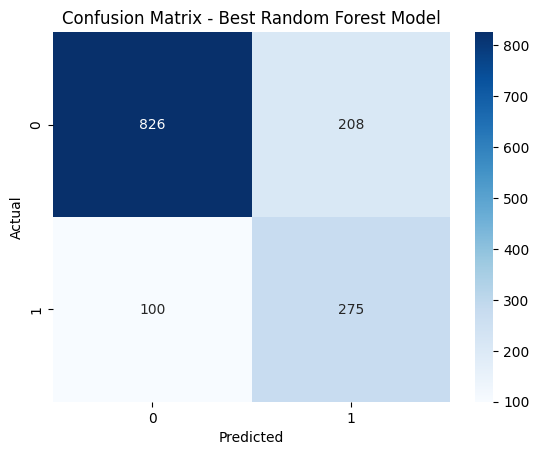

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Random Forest Model")
plt.show()


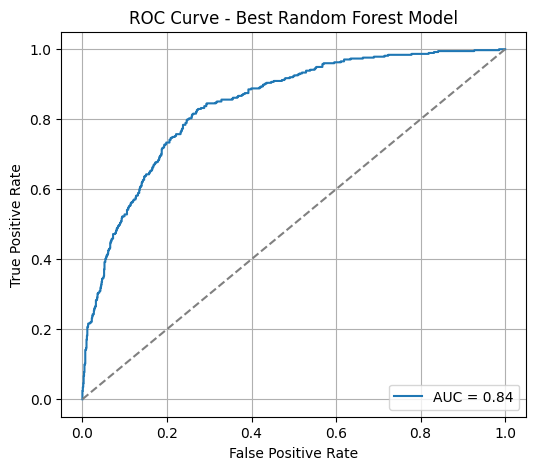

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba = best_model1.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Random Forest Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
cross_val_score(best_model1, x_test, y_test, cv=5, scoring='recall').mean()

np.float64(0.5226666666666666)

Here the recall of churn customer (class 1) is more important which is 52 % here

In [ ]:
clsRF_sm = RandomForestClassifier(random_state = random_state
                               , max_depth = 5
                              , n_estimators = 100
                              , max_features = 'sqrt'
                              , min_samples_leaf = 20 )

In [ ]:
clsRF_sm.fit(x_train_sm, y_train_sm)

RandomForestClassifier(max_depth=5, min_samples_leaf=20, random_state=42)

In [ ]:
existing_cust = df_model[df_model['Churn'] == 0]
churn_cust = df_model[df_model['Churn'] == 1]
existing_cust_feature, existing_cust_target = Create_model_df(existing_cust,
                                                              cat_cols,
                                                              nominal_cols,
                                                              binary_cols,
                                                              num_cols,
                                                              [target_col])


In [ ]:
existing_customer_churn_prob = clsRF_sm.predict_proba(existing_cust_feature)

In [ ]:
print(classification_report(y_test,clsRF_sm.predict(x_test)))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1034
           1       0.51      0.82      0.63       375

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.81      0.74      0.76      1409



In [ ]:
existing_cust['Churn_proba'] = existing_customer_churn_prob[:][:,1]

/tmp/ipython-input-380-2001261124.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



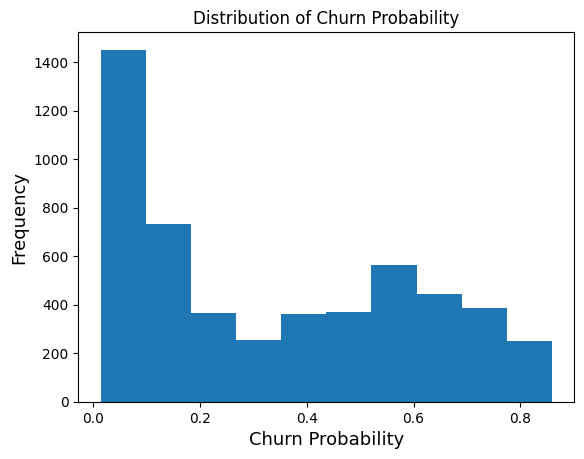

In [ ]:
plt.hist(existing_cust['Churn_prob'], bins=10)
plt.xlabel('Churn Probability',fontsize=13)
plt.ylabel('Frequency',fontsize=13)
plt.title('Distribution of Churn Probability')
plt.show()

In [ ]:
existing_cust.loc[existing_cust['Churn_proba'] >= 0.8 , 'Risk_type'] = 'Very high'
existing_cust.loc[(existing_cust['Churn_proba'] >= 0.6) & (existing_cust['Churn_proba'] < 0.8)  , 'Risk_type'] = 'High'
existing_cust.loc[(existing_cust['Churn_proba'] >= 0.4) & (existing_cust['Churn_proba'] < 0.6) , 'Risk_type'] = 'Medium'
existing_cust.loc[(existing_cust['Churn_proba'] >= 0.2) & (existing_cust['Churn_proba'] < 0.4) , 'Risk_type'] = 'Low'
existing_cust.loc[(existing_cust['Churn_proba'] > 0.0) & (existing_cust['Churn_proba'] < 0.2) , 'Risk_type'] = 'Very low'

/tmp/ipython-input-382-1875163302.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
existing_cust['Risk_type'].value_counts()

,count
Risk_type,
Very low,2291
Medium,1038
High,939
Low,727
Very high,179


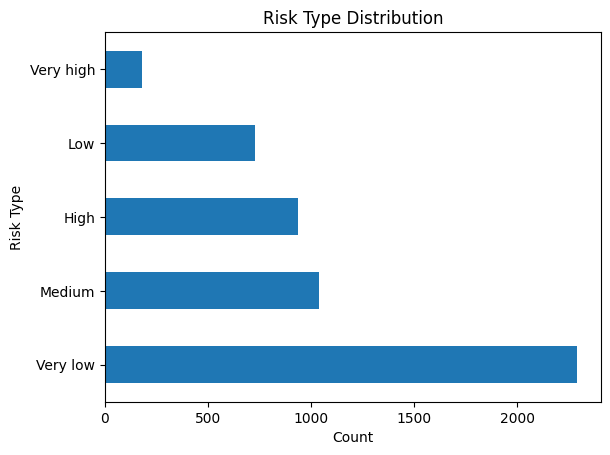

In [ ]:
existing_cust['Risk_type'].value_counts().plot(kind='barh')
plt.title('Risk Type Distribution')
plt.xlabel('Count')
plt.ylabel('Risk Type')
plt.show()

Prediction

In [ ]:
df = df_raw.copy()
df['TotalCharges'] = df['TotalCharges'].replace({" ": "0.0"}).astype(float)
df['Churn'] = df['Churn'].replace({"Yes": 1, "No": 0})
df.drop(columns = ['customerID'], inplace = True)
objects_columns = df.select_dtypes(include = "object").columns
objects_columns

/tmp/ipython-input-408-4112458943.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [ ]:

from sklearn.preprocessing import LabelEncoder
encoders = {}
for column in objects_columns:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
    encoders[column] = label_encoder

import pickle
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [ ]:
encoders

{'gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder()}

In [ ]:

from sklearn.preprocessing import StandardScaler
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
X = df.drop(columns = ['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(random_state = random_state
                               , max_depth = 5
                              , n_estimators = 100
                              , max_features = 'sqrt'
                              , min_samples_leaf = 20 )
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, min_samples_leaf=20, random_state=42)

In [ ]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1036
           1       0.52      0.84      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.75      0.77      1409



In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [ ]:

with open("best_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
with open("encoder.pkl", "rb") as f:
    encoders = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler_data =pickle.load(f)

In [ ]:
def make_predict1(input_data):
    df = pd.DataFrame([input_data])

    # Rename columns like in training
    df.rename(columns={
        'gender': 'Gender',
        'customerID': 'CustomerID',
        'Contract': 'ContractType',
        'InternetService': 'InternetServiceType',
        'tenure': 'Tenure'
    }, inplace=True)

    # ✅ Define binary mapping
    binary_map = {'Yes': 1, 'No': 0}

    # Apply binary mapping
    df['Partner'] = df['Partner'].map(binary_map)
    df['Dependents'] = df['Dependents'].map(binary_map)
    df['PhoneService'] = df['PhoneService'].map(binary_map)
    df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 0})
    df['InternetService'] = df['InternetServiceType'].map({'DSL': 1, 'Fiber optic': 1, 'No': 0})
    df['OnlineSecurity'] = df['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['OnlineBackup'] = df['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['DeviceProtection'] = df['DeviceProtection'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['TechSupport'] = df['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['StreamingTV'] = df['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['StreamingMovies'] = df['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['PaperlessBilling'] = df['PaperlessBilling'].map(binary_map)

    # Derived feature
    df['IsContracted'] = df['ContractType'].map({'One year': 1, 'Two year': 1, 'Month-to-month': 0})

    # TotalCharges cleanup
    df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['Tenure'])

    # Apply label encoders only to object columns
    for col, le in label_encoders.items():
        if col in df.columns and df[col].dtype == 'object':
            df[col] = le.transform(df[col])

    # Scale numerical features
    num_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges']
    df[num_cols] = scaler.transform(df[num_cols])

    # Align columns to training model
    df = df.reindex(columns=model_columns, fill_value=0)

    # Predict
    prediction = model.predict(df)
    proba = model.predict_proba(df)

    return prediction, proba


In [ ]:
example_input = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85,
    'customerID': '9999-9999'
}

pred, proba = make_predict1(example_input)
print("Prediction:", pred)
print("Probability:", proba)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Tenure
Feature names seen at fit time, yet now missing:
- tenure
